In [1]:
# Libraries needed 
import h5py
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image
import scipy
from scipy.spatial.distance import cdist


In [2]:
# upload data 
hdf5data_109 = h5py.File('../../Data/data_109.h5', 'r')
hdf5data_130 = h5py.File('../../Data/data_130.h5', 'r')
hdf5data_142 = h5py.File('../../Data/data_142.h5', 'r')
hdf5data_143 = h5py.File('../../Data/data_143.h5', 'r')

## Transferring detections into a dataframe 

In [3]:
def fill_rows_detections(detections, returndf):
    
    coord_detections = [np.array(vals[0].tolist()) for vals in detections]
    coord_detections = np.vstack(coord_detections)
        
    length_box = [vals[1] for vals in detections]
    width_box = [vals[2] for vals in detections]
    height_box = [vals[3] for vals in detections]
    angle_box = [vals[4] for vals in detections]
    
    returndf["X_box"] = coord_detections[:,0]
    returndf["Y_box"] = coord_detections[:,1]
    returndf["Z_box"] = coord_detections[:,2]
    returndf["length_box"], returndf["width_box"], returndf["height_box"] = length_box, width_box, height_box
    returndf["angle_box"] = angle_box
    
    return returndf

In [4]:
def df_detections(h5data,camera = None):
    
    timestamps = h5data['Timestamp']
    df = pd.DataFrame()
    
    for c, t in enumerate(timestamps):
        
        append_df = pd.DataFrame()
        
        d = h5data['Sequence'][str(c)]
        detection = np.asarray(d['Detections'])
        
        if detection.size:
            append_df = fill_rows_detections(detection, append_df)
            append_df['timestamp'] = t
            append_df['frame'] = c
        
            if camera is not None:
                append_df['camera'] = camera
        
            df = df.append(append_df)
    
    return df

In [5]:
df_109 = df_detections(hdf5data_109, 109)
df_109.reset_index(inplace=True, drop=True)
df_130 = df_detections(hdf5data_130, 130)
df_130.reset_index(inplace=True, drop=True)
df_142 = df_detections(hdf5data_142, 142)
df_142.reset_index(inplace=True, drop=True)
df_143 = df_detections(hdf5data_143, 143)
df_143.reset_index(inplace=True, drop=True)

In [6]:
def concatenate_dfs(dfs, sort_cols):
    
    df_to_concat = dfs
    df_complete = pd.concat(df_to_concat)
    df_complete.sort_values(by = sort_cols, inplace = True)
    df_complete.reset_index(inplace=True, drop=True)
    
    return df_complete

df_complete = concatenate_dfs([df_109,df_130,df_142,df_143] , ['frame', 'camera'])
df_complete

X_box      Y_box     Z_box  length_box  width_box  height_box  \
0     -11.148409  15.363879 -0.941920    1.177285   0.561967    1.334849   
1      -9.560173  18.983654 -1.377405    3.325998   0.953963    1.498572   
2       3.373729  28.175323 -1.134802    5.493111   1.930805    2.056836   
3       6.546980  26.314280 -0.862299    1.506848   0.592773    1.134711   
4      14.382445  -4.612707 -1.015361    4.811726   2.805154    1.550568   
...          ...        ...       ...         ...        ...         ...   
11740  -5.128264  26.316446 -1.150593    2.670343   1.157835    1.589266   
11741  -1.906789  -5.313489 -2.293509    3.833054   0.585950    0.395508   
11742  -1.142268  -3.922715 -2.524621   12.753714   0.377229    1.433762   
11743  14.617583 -29.436074 -1.085488    5.046473   2.802799    1.898150   
11744  10.872921  -6.188014 -0.909208    7.566915   3.033707    1.567966   

       angle_box     timestamp  frame  camera  
0       0.631927  1.574333e+09      0     109  
1      -0.120755  1.574333e+09      0     109  
2       1.514860  1.574333e+09      0     109  
3       0.424306  1.574333e+09      0     109  
4       1.004918  1.574333e+09      0     130  
...          ...           ...    ...     ...  
11740  -0.424405  1.574333e+09    749     109  
11741  -0.462055  1.574333e+09    749     142  
11742  -0.278929  1.574333e+09    749     142  
11743  -1.309933  1.574333e+09    749     143  
11744   0.852289  1.574333e+09    749     143  

[11745 rows x 10 columns]

## Frame visualization

In [7]:
def convert_to_image_space ( coordinates , world2cam , cam2im ):
    """ Input single set of coordinatetes """
    coord_4 = np.ones (4)
    coord_4[0:3] = coordinates
    cams_coord = ( np.matmul( world2cam , coord_4.T )).T
    cams_coord_4 = np.ones(4)
    
    cams_coord_4 [0:3] = cams_coord [0:3]
    ims_coord = ( np . matmul ( cam2im , cams_coord_4 .T )). T
    # Divide by z coordinate for some reason
    ims_coord [0] = ims_coord [0]/ ims_coord [2]
    ims_coord [1] = ims_coord [1]/ ims_coord [2]
    ims_coord = ims_coord [0:2]
    
    return ( ims_coord )


def visualize_frame_detections ( camera, frame_idx, figsize = None , s = 100):
    """ Input camera file, frame index and size of dot in the picture (default is 100) """
    
    frame = camera['Sequence'][str(frame_idx)]
    detected_points = np.asarray(frame['Detections'])

    x_list = []
    y_list = []

    for point in detected_points:
    
        world_pos = np.array(point[0].tolist())
        fin_pos = convert_to_image_space(world_pos, camera['TMatrixWorldToCam'], camera['ProjectionMatrix'])
        x_list.append(fin_pos[0])
        y_list.append(fin_pos[1])

    # Show image
    a = np.asarray(frame['Image'])
    
    if figsize is not None: 
        plt.figure(figsize = figsize)
        
    plt.imshow(a, cmap = 'gist_gray', zorder = 1)
    plt.scatter(x_list, y_list, s = s, color = 'hotpink', zorder = 3)
    
    return

def visualize_frame_boxes ( camera, frame_idx, figsize = None, s = 100):
    """ Input camera file, frame index and size of dot in the picture (default is 100) """
    
    frame = camera['Sequence'][str(frame_idx)]
    detected_points = np.asarray(frame['Detections'])
    
    if figsize is not None: 
        plt.figure(figsize = figsize)
        
    
    for point in detected_points:
        # first face 
        unrotated_vertex1 = np.array([+ point['Length']/2, + point['Width']/2, + point['Height']/2])
        unrotated_vertex2 = np.array([+ point['Length']/2, + point['Width']/2, - point['Height']/2])
        unrotated_vertex3 = np.array([+ point['Length']/2, - point['Width']/2, - point['Height']/2])
        unrotated_vertex4 = np.array([+ point['Length']/2, - point['Width']/2, + point['Height']/2])
        # second face 
        unrotated_vertex5 = np.array([- point['Length']/2, + point['Width']/2, + point['Height']/2])
        unrotated_vertex6 = np.array([- point['Length']/2, + point['Width']/2, - point['Height']/2])
        unrotated_vertex7 = np.array([- point['Length']/2, - point['Width']/2, - point['Height']/2])
        unrotated_vertex8 = np.array([- point['Length']/2, - point['Width']/2, + point['Height']/2])
        
        
        unrotated_vertex_list = [unrotated_vertex1, unrotated_vertex2, unrotated_vertex3, 
                                 unrotated_vertex4, unrotated_vertex5, unrotated_vertex6, 
                                 unrotated_vertex7, unrotated_vertex8]
        
        rotation_matrix = np.array([[np.cos(point['Angle']), -np.sin(point['Angle']), 0], 
                            [np.sin(point['Angle']), np.cos(point['Angle']), 0], 
                            [0,0,1]])
        
        rotated_vertex_list = np.array([rotation_matrix.dot(v) for v in unrotated_vertex_list])
        rotated_vertex_list = rotated_vertex_list + np.array([point['Pos']['X'], point['Pos']['Y'], point['Pos']['Z']])
        
        vertex_im_list = [convert_to_image_space(v, camera['TMatrixWorldToCam'], camera['ProjectionMatrix']) for v in rotated_vertex_list]
        
        
        combinations = [(i,i+1) for i in range(3)] + [(3,0)] + [(i,i+1) for i in range(4,7)] + [
            (7,4)] + [(i,i+4) for i in range(4)]
        
        for (i,j) in combinations: 
            vertex_x_list = [vertex_im_list[i][0],vertex_im_list[j][0]]
            vertex_y_list = [vertex_im_list[i][1],vertex_im_list[j][1]]
            plt.plot(vertex_x_list, vertex_y_list, color = 'b', zorder = 2)
        
        
        
    visualize_frame_detections ( camera, frame_idx, s = s )
    
    return

In [8]:
visualize_frame_detections(hdf5data_109,260, figsize = (12,12))

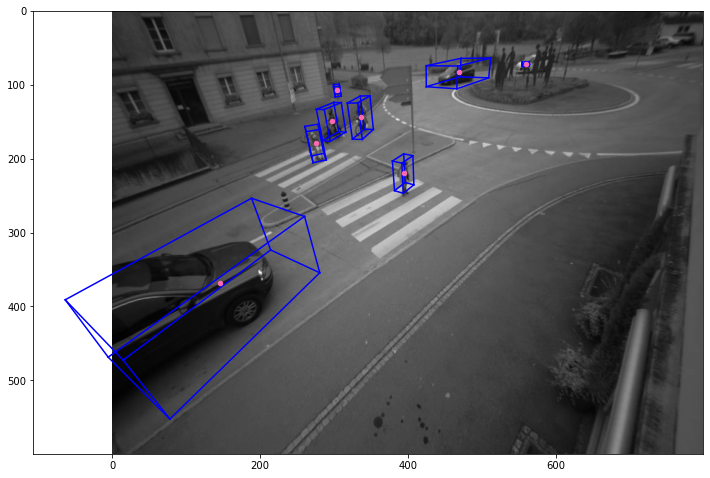

In [9]:
visualize_frame_boxes(hdf5data_109, 260, figsize = (12,12), s = 20)

## Use Df


In [10]:
df_complete

X_box      Y_box     Z_box  length_box  width_box  height_box  \
0     -11.148409  15.363879 -0.941920    1.177285   0.561967    1.334849   
1      -9.560173  18.983654 -1.377405    3.325998   0.953963    1.498572   
2       3.373729  28.175323 -1.134802    5.493111   1.930805    2.056836   
3       6.546980  26.314280 -0.862299    1.506848   0.592773    1.134711   
4      14.382445  -4.612707 -1.015361    4.811726   2.805154    1.550568   
...          ...        ...       ...         ...        ...         ...   
11740  -5.128264  26.316446 -1.150593    2.670343   1.157835    1.589266   
11741  -1.906789  -5.313489 -2.293509    3.833054   0.585950    0.395508   
11742  -1.142268  -3.922715 -2.524621   12.753714   0.377229    1.433762   
11743  14.617583 -29.436074 -1.085488    5.046473   2.802799    1.898150   
11744  10.872921  -6.188014 -0.909208    7.566915   3.033707    1.567966   

       angle_box     timestamp  frame  camera  
0       0.631927  1.574333e+09      0     109  
1      -0.120755  1.574333e+09      0     109  
2       1.514860  1.574333e+09      0     109  
3       0.424306  1.574333e+09      0     109  
4       1.004918  1.574333e+09      0     130  
...          ...           ...    ...     ...  
11740  -0.424405  1.574333e+09    749     109  
11741  -0.462055  1.574333e+09    749     142  
11742  -0.278929  1.574333e+09    749     142  
11743  -1.309933  1.574333e+09    749     143  
11744   0.852289  1.574333e+09    749     143  

[11745 rows x 10 columns]

In [11]:
df_complete[df_complete['frame'] == 0]

X_box      Y_box     Z_box  length_box  width_box  height_box  \
0 -11.148409  15.363879 -0.941920    1.177285   0.561967    1.334849   
1  -9.560173  18.983654 -1.377405    3.325998   0.953963    1.498572   
2   3.373729  28.175323 -1.134802    5.493111   1.930805    2.056836   
3   6.546980  26.314280 -0.862299    1.506848   0.592773    1.134711   
4  14.382445  -4.612707 -1.015361    4.811726   2.805154    1.550568   
5  27.471277   9.154471 -0.657809    2.640507   0.653304    1.245023   
6  10.591985 -33.300211 -1.254730    3.106008   2.026976    2.356834   
7   2.417817 -32.064833 -0.609711    0.641007   0.489730    0.741013   
8  13.233552  -5.117304 -0.707404    9.933850   2.673657    1.161759   

   angle_box     timestamp  frame  camera  
0   0.631927  1.574333e+09      0     109  
1  -0.120755  1.574333e+09      0     109  
2   1.514860  1.574333e+09      0     109  
3   0.424306  1.574333e+09      0     109  
4   1.004918  1.574333e+09      0     130  
5  -0.802791  1.574333e+09      0     130  
6   1.390347  1.574333e+09      0     143  
7  -0.615712  1.574333e+09      0     143  
8   1.067465  1.574333e+09      0     143

In [12]:
def visualize_alldetections(df, frame_idx):
    
    x = df['X_box'][df['frame'] == frame_idx]
    y = df['Y_box'][df['frame'] == frame_idx]

    plt.scatter(x,y)
    display(df[df['frame'] == frame_idx])
    
visualize_alldetections(df_complete, 700)

X_box      Y_box     Z_box  length_box  width_box  height_box  \
11357   9.566447  -6.246071 -1.441673    3.720963   0.572385    2.633472   
11358   9.489338   4.701700 -0.958520    7.711663   2.026856    1.841724   
11359  -9.944874  16.836832 -1.328071    2.133689   0.833814    1.746858   
11360  -9.224591  20.069888 -1.216641    1.904620   1.459614    1.583196   
11361  12.058387  -1.509373 -1.051932    5.431972   5.183691    1.601880   
11362  20.449101   0.293247 -1.128958    5.298687   2.116255    1.910967   
11363   7.194283 -16.151469 -2.296220    2.713412   0.796659    0.739611   
11364  12.137132 -19.301827 -1.700559   13.322793   3.820700    3.906734   
11365  11.474680   2.025208 -0.725260    4.221231   0.541156    1.293814   

       angle_box     timestamp  frame  camera  
11357  -1.556818  1.574333e+09    700     109  
11358  -1.251739  1.574333e+09    700     109  
11359   0.634689  1.574333e+09    700     109  
11360  -0.434042  1.574333e+09    700     109  
11361  -1.110625  1.574333e+09    700     130  
11362   0.539801  1.574333e+09    700     130  
11363  -0.756155  1.574333e+09    700     142  
11364  -1.271880  1.574333e+09    700     143  
11365  -1.473528  1.574333e+09    700     143

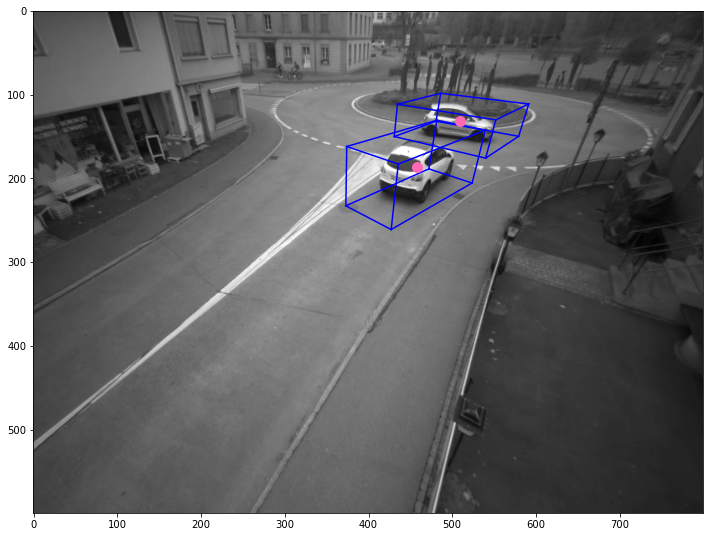

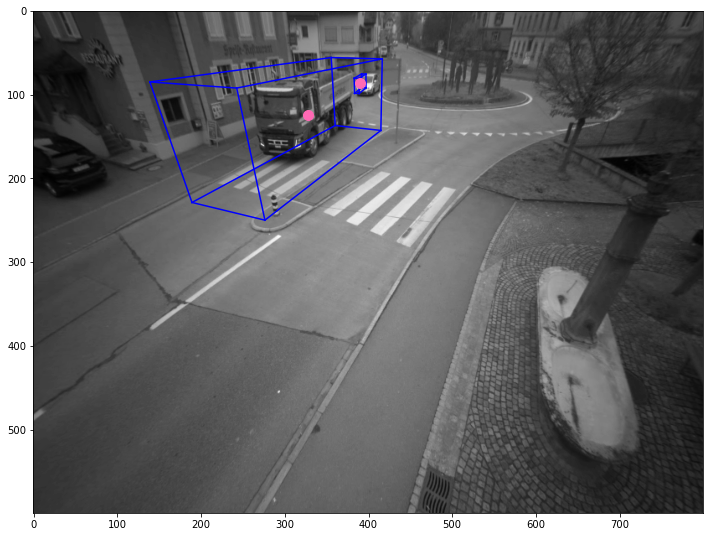

In [13]:
visualize_frame_boxes(hdf5data_109, 700, figsize = (12,12))
visualize_frame_boxes(hdf5data_130, 700, figsize = (12,12))
visualize_frame_boxes(hdf5data_143, 700, figsize = (12,12))

In [337]:
# Obj = { 'x' : 1, 'y': 1, 'z': 1, 'l': 10, 'w': 10, 'h' : 10, 'angle' : np.pi/2}

deltaT = 0.08
threshold = 5

class Track:
    
    def __init__(self, ID, OBJ, FRAME, threshold = threshold):
        self.ID = ID
        self.status = 'New'  #New, Pending, Active, Inactive
        self.objects = [OBJ]
        self.x, self.y, self.z = OBJ.x, OBJ.y, OBJ.z
        self.frames = [FRAME]
        self.velocity = []
        self.type = None
        self.threshold = threshold
        self.filter = None
        
        self.new_time = 0
        self.pending_time = 0
    
    def update(self, OBJ, FRAME):
        
        if OBJ is not None:
            self.objects.append(OBJ)
            self.frames.append(FRAME)
            self.x, self.y, self.z = OBJ.x, OBJ.y, OBJ.z #We should use KF.filter
            self.status = 'Active'
        
        if OBJ is None and self.status == 'New':
            if self.new_time == 1: self.status = 'Removed'
            else: self.new_time += 1
        
        if OBJ is None and self.status == 'Active':
            self.status = 'Pending'
            self.pending_time += 1
        
        if OBJ is None and self.status == 'Pending':
            if self.pending_time == 5: self.status = 'Inactive'
            else: self.pending_time += 1
        
        return
    
    def set_status(self, status):
        self.status = status
        
        return
    
    def compute_vel ( self, OBJ ): #TO DO WITH KALMAN FILTERS NOT THIS SH*T
        vx = (OBJ['x'] - self.objects[-1]['x'])/deltaT
        vy = (OBJ['y'] - self.objects[-1]['y'])/deltaT
        vz = (OBJ['z'] - self.objects[-1]['z'])/deltaT
        
        self.velocity.append((vx,vy, vz))
        
        return
    
    def set_type( self, TYPE ):
        self.type = TYPE
        set_threshold()
        return
    
    def set_threshold (self):
        
        if type == 'car':
            self.threshold = 3
        
        else:
            self.threshold = 10
            
        return

class Object:
    def __init__(self, x, y, z, l, w, h, angle):
        self.x = x
        self.y = y
        self.z = z
        self.length = l
        self.width = w
        self.height = h
        self.angle = angle


In [225]:
#Fill this functions with chosen approach

#Using Nearest Neighbour -> not right, will always connect a track to an object
def track_detection_association(track_coord, obj_coord):
    ''' Function for association between detections and tracks'''
    
    dists = cdist(track_coord, obj_coord, 'euclidean') 
    associations = np.argmin(dists, axis=1)
    
    associations[np.min(dists, axis = 1) > 0.5] = -1
    #print(associations)
    return associations

def associate(track_coord, tracks, status, obj_list, frame_index):
    
    if track_coord.size and len(obj_list) > 0:
        
        obj_coord = [(obj.x, obj.y, obj.z) for obj in obj_list]
        associations = track_detection_association(track_coord, obj_coord)
        print(associations)
        
        for index, ass in enumerate(associations):
            if ass == -1:
                tracks[status][index].update(None, frame_index)
            else:
                tracks[status][index].update(obj_list[ass], frame_index)

        obj_list = np.delete(obj_list, associations)
    
    return tracks, obj_list

In [338]:
class Tracker:
    
    def __init__(self, dfs):
        self.tracks = {'Active': [], 'Pending': [], 'Inactive': [], 'New': [], 'Removed': []}
        self.dataframe = concatenate_dfs(dfs, ['frame', 'camera'])
        self.track_id = 0
        self.frame_index = 0
    
    def update_tracks(self):
        
        for tr in self.tracks['New'][::-1]:
            if tr.status != 'New':
                self.tracks['New'].remove(tr)
                self.tracks[tr.status].append(tr)
        
        for tr in self.tracks['Pending'][::-1]:
            if tr.status != 'Pending':
                self.tracks['Pending'].remove(tr)
                self.tracks[tr.status].append(tr)
        
        for tr in self.tracks['Active'][::-1]:
            if tr.status != 'Active':
                self.tracks['Active'].remove(tr)
                self.tracks[tr.status].append(tr)
        
        return
    
    def next_step(self):
        self.frame_index += 1
    
    def analyze_frame(self):
        
        frame = self.dataframe[self.dataframe['frame'] == self.frame_index]
        frame.reset_index(inplace=True, drop=True)
        obj_list = []
        
        # Extract all the detections in the frame and define coordinates
        for index, row in frame.iterrows():
            obj = Object(row['X_box'], row['Y_box'], row['Z_box'], row['length_box'], row['width_box'], row['height_box'], row['angle_box'])
            obj_list.append(obj)

        obj_list = np.array(obj_list)
        
        # At first we use Active Tracks
        track_act_coord = np.array([[t.x, t.y, t.z] for t in self.tracks['Active']]) #We should use KF.predict here and not consider only the new set
        self.tracks, obj_list = associate(track_act_coord, self.tracks, 'Active', obj_list, self.frame_index)

        #Then we use tracks set as New
        track_new_coord = np.array([[t.x, t.y, t.z] for t in self.tracks['New']]) #We should use KF.predict here and not consider only the new set
        self.tracks, obj_list = associate(track_new_coord, self.tracks, 'New', obj_list, self.frame_index)

        #Then we use tracks set as Pending
        track_pending_coord = np.array([[t.x, t.y, t.z] for t in self.tracks['Pending']]) #We should use KF.predict here and not consider only the new set
        self.tracks, obj_list = associate(track_pending_coord, self.tracks, 'Pending', obj_list, self.frame_index)

        
        # Check status of all tracks
        self.update_tracks()
        
        #Create new tracks
        for obj in obj_list:
            tr = Track(self.track_id, obj, self.frame_index)
            self.track_id += 1
            self.tracks['New'].append(tr)
        
        #Go to the next frame
        self.next_step()

In [339]:
TrackTrack = Tracker([df_109,df_130,df_142,df_143])

In [341]:
for _ in range(100): TrackTrack.analyze_frame()

[ 1  2  3  4  5  6  8  9 10]
[-1 10  9  6 -1  4  3  2  1]
[ 0 -1]
[10  9  7  5  4  2  1  0]
[ 2  1 -1]
[-1 -1]
[13 12  9  6  4  2  1 -1  7 -1]
[-1]
[-1 -1]
[11 10  8  5  4  2  1  7]
[-1  1 -1 -1]
[-1 -1 -1 -1]
[12 11  8  5  4  2  1 -1  3]
[-1 -1 -1 -1  1]
[-1 -1 -1 -1]
[11 -1 -1  5  4  2  1  3  6]
[-1 -1 -1]
[-1  0 -1]
[ 9  5  4  2  1  3 -1  0]
[-1 -1 -1 -1  1]
[-1 -1 -1 -1]
[9 5 4 2 1 3 0 7]
[-1 -1  0]
[-1 -1 -1 -1]
[ 9  4  3 -1 -1  2  0  7 -1]
[3]
[-1 -1 -1 -1]
[ 9  4  3  2 -1  7  8]
[ 1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1]
[10  4  3  2  7  8  1]
[-1 -1 -1  0  1  2]
[-1 -1 -1 -1]
[ 8  4  3  2  6  7  1 -1 -1 -1]
[-1]
[-1 -1 -1]
[10  4  3  2  7  8  1]
[-1  0]
[-1 -1 -1 -1 -1 -1]
[ 8  4  2  3  6 -1  1  0]
[ 0 -1 -1]
[-1 -1 -1]
[ 6  3  1  2  4  0 -1 -1]
[-1 -1]
[-1 -1 -1 -1]
[9 3 1 2 6 0]
[-1 -1 -1 -1 -1 -1]
[8 4 2 3 6 1]
[-1 -1  2 -1 -1]
[-1 -1 -1]
[ 9  3  1  2  6  0 -1]
[-1 -1 -1 -1 -1  1]
[-1 -1 -1]
[10  3  1  2  6  0  5]
[-1 -1 -1]
[-1 -1 -1]
[12  3  1  2  7  0  5]
[-1 -1  0 -1 -1 -1]
[2]
[

X_box      Y_box     Z_box  length_box  width_box  height_box  \
9   10.193464  -3.254121 -0.711990    1.412921   0.266124    0.460025   
10 -11.137152  15.415920 -0.911968    1.352618   0.546684    1.370234   
11  -9.487168  19.018149 -1.403667    2.751621   1.204600    1.533254   
12   3.314025  27.995880 -1.186819    5.750861   2.279514    2.025559   
13   6.557454  26.324931 -0.863639    1.568051   0.584425    1.166256   
14  14.292184  -4.719566 -1.036344    3.694674   2.879994    1.621184   
15  27.366480   9.388028 -0.620996    2.423051   0.704623    1.189200   
16  -8.244665 -16.619673 -2.642268    5.584267   0.324819    0.769942   
17  10.460591 -32.968130 -1.340568    3.902771   2.242807    2.530253   
18   2.427649 -32.079108 -0.605736    0.617645   0.512637    0.735474   
19  13.044299  -5.497306 -0.693706   10.872630   3.128635    0.948253   

    angle_box     timestamp  frame  camera  
9    1.337511  1.574333e+09      1     109  
10   0.708852  1.574333e+09      1     109  
11  -0.508305  1.574333e+09      1     109  
12   1.530818  1.574333e+09      1     109  
13   0.442498  1.574333e+09      1     109  
14   0.862217  1.574333e+09      1     130  
15  -0.820607  1.574333e+09      1     130  
16  -0.745784  1.574333e+09      1     142  
17  -1.561048  1.574333e+09      1     143  
18  -0.749255  1.574333e+09      1     143  
19   1.164406  1.574333e+09      1     143

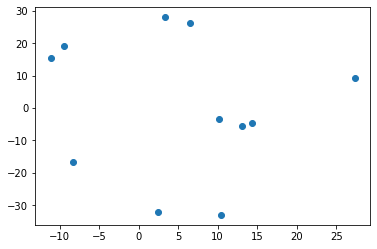

In [350]:
visualize_alldetections(df_complete, 1)

In [351]:
#visualize_frame_boxes(hdf5data_109, 68, figsize = (12,12))
#visualize_frame_boxes(hdf5data_130, 68, figsize = (12,12))
visualize_frame_boxes(hdf5data_143, 2, figsize = (12,12))

In [ ]:
%%timeit

TrackTrack = Tracker([df_109,df_130,df_142,df_143])
frame = TrackTrack.dataframe[TrackTrack.dataframe['frame'] == TrackTrack.frame_index]
display(frame)
### Setup at frame 0
obj_list = []

for index, row in frame.iterrows():
    obj = Object(row['X_box'], row['Y_box'], row['Z_box'], row['length_box'], row['width_box'], row['height_box'], row['angle_box'])
    obj_list.append(obj)
    tr = Track(TrackTrack.track_id, obj, TrackTrack.frame_index)
    TrackTrack.tracks['New'].append(tr)


### New Frame
TrackTrack.next_step()
frame = TrackTrack.dataframe[TrackTrack.dataframe['frame'] == TrackTrack.frame_index]
frame.reset_index(inplace=True, drop=True)
display(frame)
obj_list = []

### Retrieve objects
for index, row in frame.iterrows():
    obj = Object(row['X_box'], row['Y_box'], row['Z_box'], row['length_box'], row['width_box'], row['height_box'], row['angle_box'])
    obj_list.append(obj)

obj_list = np.array(obj_list)

### Associate 
obj_coord = [(obj.x, obj.y, obj.z) for obj in obj_list]

# At first we use Active Tracks
track_act_coord = np.array([[t.x, t.y, t.z] for t in TrackTrack.tracks['Active']]) #We should use KF.predict here and not consider only the new set
TrackTrack.tracks, obj_list = associate(track_act_coord, TrackTrack.tracks, 'Active', obj_coord, obj_list, TrackTrack.frame_index)

#Then we use tracks set as New
track_new_coord = np.array([[t.x, t.y, t.z] for t in TrackTrack.tracks['New']]) #We should use KF.predict here and not consider only the new set
TrackTrack.tracks, obj_list = associate(track_new_coord, TrackTrack.tracks, 'New', obj_coord, obj_list, TrackTrack.frame_index)

#Then we use tracks set as Pending
track_pending_coord = np.array([[t.x, t.y, t.z] for t in TrackTrack.tracks['Pending']]) #We should use KF.predict here and not consider only the new set
TrackTrack.tracks, obj_list = associate(track_pending_coord, TrackTrack.tracks, 'Pending', obj_coord, obj_list, TrackTrack.frame_index)

#Go to the next frame
TrackTrack.update_tracks()

for obj in obj_list:
    tr = Track(TrackTrack.track_id, obj, TrackTrack.frame_index)
    TrackTrack.tracks['New'].append(tr)

In [ ]:
TrackTrack.tracks